# AMOC variability in cold vs warm phases

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch
import seaborn as sns

In [2]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33025 instead
  expected, actual


In [5]:
client

Client Scheduler: tcp://127.0.0.1:32853 Dashboard: http://127.0.0.1:33025/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [7]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [8]:
exp_list = ['FOCI_GJK001','FOCI_GJK006']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [9]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*PSI.nc


In [12]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [13]:
ds_moc

<xarray.Dataset>
Dimensions:    (time: 25200, y: 511, x: 1, depthw: 46)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
Dimensions without coordinates: y, x
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [11]:
amoc_lat = 45
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values
# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

349 45.081944


In [11]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3200), slice(3200,3500)]

#period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
#period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

# New definition of phases based on analysing PC1
periods = [ [2000,2450], [2550,3150], [3300,3510] ]
period_list = []
period_list_yr = []
for p in periods:
    period_list.append(slice('%d-01-01' % (p[0],), '%d-01-01' % (p[1],)))
    period_list_yr.append(slice(p[0],p[1]))

## Differences in time mean

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py

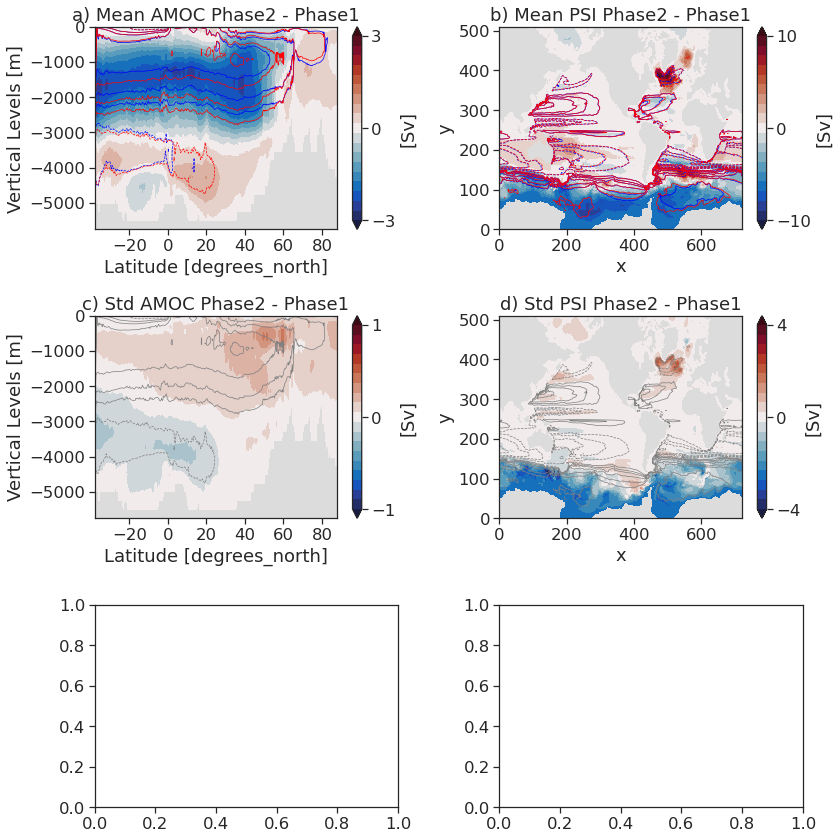

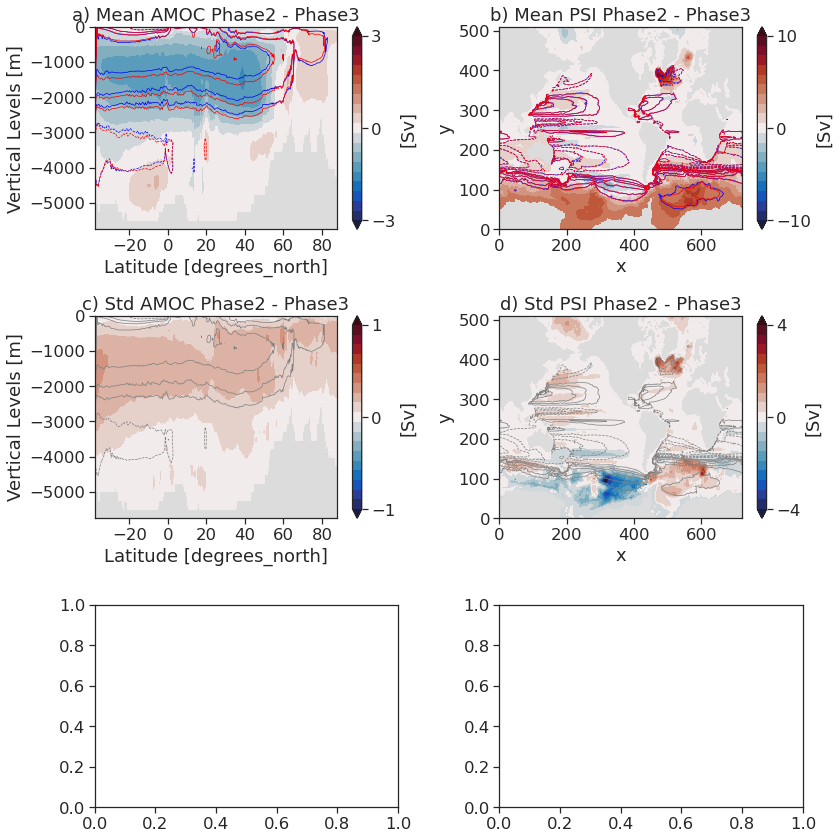

In [18]:
ip = 1 # cold phase

period2 = period_list[ip]

for jp in [0,2]:
    
    period1 = period_list[jp]
    
    fig, ax = plt.subplots(3,2,figsize=(12,12))
    bg_color = 'Gainsboro'

    ##
    ## Compute AMOC
    ## 
    _amoc1 = ds_moc['zomsfatl'].sel(x=0).sel(time=period1).groupby('time.year').mean('time').compute()
    _amoc2 = ds_moc['zomsfatl'].sel(x=0).sel(time=period2).groupby('time.year').mean('time').compute()
    amoc_lat = ds_moc['nav_lat'].isel(time=0,x=0)
    _amoc1 = _amoc1.where(_amoc1 != 0).assign_coords(y=amoc_lat)
    _amoc2 = _amoc2.where(_amoc2 != 0).assign_coords(y=amoc_lat)
    
    ##
    ## Compute barotropic stream function
    ##
    _baro1 = ds_psi['sobarstf'].sel(time=period1).groupby('time.year').mean('time').compute() * 1e-6
    _baro2 = ds_psi['sobarstf'].sel(time=period2).groupby('time.year').mean('time').compute() * 1e-6

    ##
    ## Differences
    ##
    amoc_diff = _amoc2.mean('year') - _amoc1.mean('year')
    baro_diff = (_baro2.mean('year') - _baro1.mean('year')).where(da_orca05_mask > 0)

    ##
    ## Mean AMOC
    ##
    mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
    mlevels2 = np.linspace(-3,3,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    amoc_diff.plot.contourf(ax=ax[0,0], levels=mlevels2, extend='both',
                            cmap=cmocean.cm.balance,
                            cbar_kwargs=cbar_kwargs)
    _amoc2.mean('year').plot.contour(ax=ax[0,0],colors='blue',levels=mlevels,linewidths=0.7)
    _amoc1.mean('year').plot.contour(ax=ax[0,0],colors='red',levels=mlevels,linewidths=0.7)
    ax[0,0].set_title('a) Mean AMOC %s - %s' % (label_list[ip],label_list[jp]))
    ax[0,0].set_facecolor(bg_color)
    ax[0,0].set_xlim([-38,88])
    ax[0,0].set_xticks([-20,0,20,40,60,80])

    ##
    ## AMOC standard dev.
    ##
    run1,run2=20,100
    _amoc1_f = _amoc1.rolling(year=run1,center=True).mean() - _amoc1.rolling(year=run2,center=True).mean()
    _amoc2_f = _amoc2.rolling(year=run1,center=True).mean() - _amoc2.rolling(year=run2,center=True).mean()
    _amoc1_std = _amoc1_f.std('year')
    _amoc2_std = _amoc2_f.std('year')
    amoc_std_diff = _amoc2_std - _amoc1_std
    
    mlevels2 = np.linspace(-1,1,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    (amoc_std_diff).plot.contourf(ax=ax[1,0],
                                  levels=mlevels2,
                                  extend='both',
                                  cbar_kwargs=cbar_kwargs,
                                  cmap=cmocean.cm.balance,
                                  )
    _amoc1.mean('year').plot.contour(ax=ax[1,0],colors='gray',levels=mlevels,linewidths=0.7)
    ax[1,0].set_title('c) Std AMOC %s - %s' % (label_list[ip],label_list[jp]))
    ax[1,0].set_facecolor(bg_color)
    ax[1,0].set_xlim([-38,88])
    ax[1,0].set_xticks([-20,0,20,40,60,80])

    ##
    ## Mean barotropic
    ##
    mlevels = np.array([-150,-100,-80,-50,-30,-20,-10,10,20,30,50,80,100,150])
    mlevels2 = np.linspace(-10,10,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    baro_diff.plot.contourf(ax=ax[0,1], levels=mlevels2, 
                            extend='both', rasterized=True,
                            cmap=cmocean.cm.balance,
                            cbar_kwargs=cbar_kwargs)
    _baro2.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[0,1],colors='blue',levels=mlevels,linewidths=0.7)
    _baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[0,1],colors='red',levels=mlevels,linewidths=0.7)
    ax[0,1].set_title('b) Mean PSI %s - %s' % (label_list[ip],label_list[jp]))
    ax[0,1].set_facecolor(bg_color)

    ##
    ## Barotropic standard dev.
    ##
    _baro1_f = _baro1.rolling(year=run1,center=True).mean() - _baro1.rolling(year=run2,center=True).mean()
    _baro2_f = _baro2.rolling(year=run1,center=True).mean() - _baro2.rolling(year=run2,center=True).mean()
    _baro1_std = _baro1_f.std('year')
    _baro2_std = _baro2_f.std('year')
    baro_std_diff = (_baro2_std - _baro1_std).where(da_orca05_mask > 0)
    mlevels2 = np.linspace(-4,4,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    (baro_std_diff).plot.contourf(ax=ax[1,1],
                                  levels=mlevels2,
                                  extend='both',
                                  cbar_kwargs=cbar_kwargs,
                                  cmap=cmocean.cm.balance,
                                  rasterized=True)
    _baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[1,1],colors='gray',levels=mlevels,linewidths=0.7)
    ax[1,1].set_title('d) Std PSI %s - %s' % (label_list[ip],label_list[jp]))
    ax[1,1].set_facecolor(bg_color)

    ##
    ## AMOC and Drake Pass time series
    ##
    #amoc_lat = ds_moc_all[i1]['nav_lat'][0,amoc_j,0]
    #print('AMOC taken at latitude: %f' % (amoc_lat,))
    #amoc_max1 = amoc1.isel(y=amoc_j).max('depthw').compute()
    #amoc_max2 = amoc2.isel(y=amoc_j).max('depthw').compute()
    #drake1 = (baro1.sel(x=436,y=51) - baro1.sel(x=436,y=119)).compute()
    #drake2 = (baro2.sel(x=436,y=51) - baro2.sel(x=436,y=119)).compute()

    ##
    ## PSD
    ##
    #freq1, amoc_psd1 = welch(amoc_max1,fs=1)
    #freq2, amoc_psd2 = welch(amoc_max2,fs=1)
    
    #ax[2,0].loglog(freq1,amoc_psd1,c='blue',label='%s' % (label_list[i1],))
    #ax[2,0].loglog(freq2,amoc_psd2,c='red',label='%s' % (label_list[i2],))
    #ax[2,0].set_xlabel('Frequency [/year]');
    #ax[2,0].set_ylabel('[Sv**2 year]');
    #ax[2,0].set_title('e) AMOC PSD');
    #ax[2,0].legend()

    #freq1, drake_psd1 = welch(drake1,fs=1)
    #freq2, drake_psd2 = welch(drake2,fs=1)
    
    #ax[2,1].loglog(freq1,drake_psd1,c='blue',label='%s' % (label_list[i1],))
    #ax[2,1].loglog(freq2,drake_psd2,c='red',label='%s' % (label_list[i2],))
    #ax[2,1].set_xlabel('Frequency [/year]');
    #ax[2,1].set_ylabel('[Sv**2 year]');
    #ax[2,1].set_title('f) Drake Passage PSD');
    #ax[2,1].legend()

    fig.tight_layout()
    fig.savefig('figures/Fig_PSD_%s_vs_%s.pdf' % (label_list[ip],label_list[jp]),format='pdf')

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


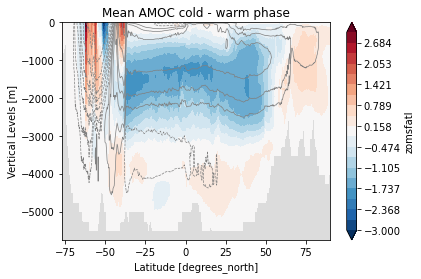

In [13]:
fig, ax = plt.subplots(1,1)

mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
mlevels2 = np.linspace(-3,3,20)
amoc_diff.plot.contourf(ax=ax,levels=mlevels2,rasterized=True)
amoc1.mean('year').plot.contour(ax=ax,colors='gray',levels=mlevels,linewidths=0.7)
ax.set_title('Mean AMOC cold - warm phase')
ax.set_facecolor(bg_color)

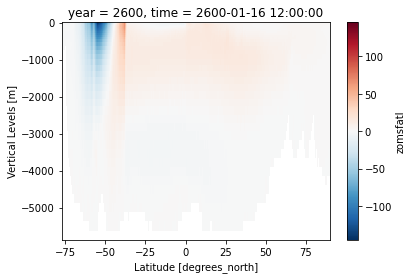

In [14]:

z = amoc1.where(amoc1 != 0).sortby('y')
z[0,:,:].plot()